In [1]:
import os
import sys
p = '..'
while not os.path.isdir(p + '/notebooks'):
    p += '/..'
sys.path.append(p) # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)


In [2]:
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
symbols += 'DOGE,SFP,DYDX,AXS,CHZ,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')

provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            'table': 'binance_ohlcv',
            'symbols': ['{}USDT'.format(x) for x in symbols],
        }
    },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def merge_data(dfs):
    df = dfs[0]
    df['symbol'] = df['symbol'].str.replace('USDT', '')
    df = df.set_index(['timestamp', 'symbol']).sort_index()
    return df

df = merge_data(dfs)
df = df.dropna()
df.to_pickle('/tmp/df_binance_ohlcv.pkl')
display(df)

,timestamp,symbol,op,hi,lo,cl,volume,amount,trades,buy_volume,...,twap,twap_5m,cl_std,cl_diff_std,hi_twap,lo_twap,hi_op_max,lo_op_min,ln_hi_lo_mean,ln_hi_lo_sqr_mean
0,2020-01-15 12:00:00+00:00,BTCUSDT,8738.060,8800.000,8727.000,8771.690,8946.680,7.850456e+07,13798.0,4436.936,...,8775.769667,8778.084167,14.040439,6.881349,8780.483500,8771.374500,5.326833,-3.782167,0.001038,1.380802e-06
1,2020-01-05 05:00:00+00:00,BTCUSDT,7456.400,7465.050,7445.000,7457.480,2471.459,1.842765e+07,5214.0,1156.706,...,7455.926000,7456.212500,4.514219,3.336579,7457.473167,7454.343833,1.557333,-1.572000,0.000420,2.715494e-07
2,2020-01-21 20:00:00+00:00,BTCUSDT,8536.110,8728.300,8534.000,8724.330,20860.656,1.809620e+08,40863.0,11522.434,...,8687.885833,8695.270000,33.958820,13.051842,8694.736000,8678.471167,10.014833,-6.250000,0.001875,6.025309e-06
3,2019-12-28 16:00:00+00:00,BTCUSDT,7300.410,7329.000,7273.350,7317.000,6115.423,4.467909e+07,10777.0,2834.010,...,7311.903000,7312.781667,12.521396,5.569986,7314.868333,7308.164500,3.294667,-3.409167,0.000917,1.126881e-06
4,2020-01-11 16:00:00+00:00,BTCUSDT,8101.690,8186.230,8070.560,8172.750,10841.977,8.823840e+07,22418.0,5702.753,...,8137.871333,8140.311667,27.135540,8.615129,8143.158333,8131.301333,6.621833,-5.235167,0.001457,2.541703e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493302,2020-05-04 01:00:00+00:00,LINKUSDT,3.672,3.698,3.578,3.612,1268193.800,4.599263e+06,8847.0,542128.370,...,3.635883,3.633083,0.030954,0.006730,3.640633,3.631333,0.003750,-0.005550,0.002561,9.404468e-06
493303,2020-04-17 09:00:00+00:00,LINKUSDT,3.448,3.497,3.427,3.477,1297883.270,4.498443e+06,7110.0,693528.780,...,3.465283,3.466417,0.018687,0.004813,3.468367,3.461483,0.003533,-0.003350,0.001987,4.581436e-06
493304,2020-04-26 03:00:00+00:00,LINKUSDT,3.805,3.805,3.785,3.790,380246.010,1.443025e+06,1939.0,109266.420,...,3.795600,3.796000,0.004110,0.002653,3.797067,3.794167,0.001033,-0.001867,0.000764,7.844254e-07
493305,2020-04-21 09:00:00+00:00,LINKUSDT,3.499,3.512,3.416,3.451,2535090.610,8.760246e+06,11348.0,1291856.150,...,3.468767,3.466667,0.027334,0.006081,3.473417,3.464900,0.003650,-0.004867,0.002461,7.896742e-06


op           hi           lo  \
timestamp                 symbol                                         
2019-09-08 17:00:00+00:00 BTC     10000.0000  10000.00000  10000.00000   
2019-09-08 18:00:00+00:00 BTC     10000.0000  10000.00000  10000.00000   
2019-09-08 19:00:00+00:00 BTC     10000.0000  10357.53000  10000.00000   
2019-09-08 20:00:00+00:00 BTC     10340.1200  10368.64000  10334.54000   
2019-09-08 21:00:00+00:00 BTC     10351.4200  10391.90000  10324.77000   
...                                      ...          ...          ...   
2022-11-14 15:00:00+00:00 SFP         0.6228      0.68310      0.62260   
                          SOL        14.1220     14.20000     13.46000   
                          SUSHI       1.2680      1.27100      1.23700   
                          TRX         0.0496      0.04989      0.04887   
                          XRP         0.3459      0.34710      0.34180   

                                           cl        volume        amount  \
timestamp                 symbol                                            
2019-09-08 17:00:00+00:00 BTC     10000.00000  2.000000e-03  2.000000e+01   
2019-09-08 18:00:00+00:00 BTC     10000.00000  0.000000e+00  0.000000e+00   
2019-09-08 19:00:00+00:00 BTC     10340.12000  4.716590e+02  4.879792e+06   
2019-09-08 20:00:00+00:00 BTC     10351.42000  5.832710e+02  6.037733e+06   
2019-09-08 21:00:00+00:00 BTC     10391.90000  6.897590e+02  7.136799e+06   
...                                       ...           ...           ...   
2022-11-14 15:00:00+00:00 SFP         0.66580  2.746748e+08  1.798067e+08   
                          SOL        13.70500  4.429933e+06  6.109722e+07   
                          SUSHI       1.26100  5.684435e+06  7.124715e+06   
                          TRX         0.04926  1.787243e+08  8.816763e+06   
                          XRP         0.34560  6.575349e+07  2.267832e+07   

                                    trades    buy_volume    buy_amount  \
timestamp                 symbol                                         
2019-09-08 17:00:00+00:00 BTC          2.0  1.000000e-03  1.000000e+01   
2019-09-08 18:00:00+00:00 BTC          0.0  0.000000e+00  0.000000e+00   
2019-09-08 19:00:00+00:00 BTC        562.0  0.000000e+00  0.000000e+00   
2019-09-08 20:00:00+00:00 BTC        731.0  3.400000e-02  3.519712e+02   
2019-09-08 21:00:00+00:00 BTC        827.0  4.000000e-03  4.138500e+01   
...                                    ...           ...           ...   
2022-11-14 15:00:00+00:00 SFP     563683.0  1.444676e+08  9.460592e+07   
                          SOL     113101.0  2.064711e+06  2.844876e+07   
                          SUSHI    18439.0  3.016562e+06  3.782671e+06   
                          TRX      24687.0  9.287866e+07  4.583225e+06   
                          XRP      33520.0  3.279916e+07  1.131232e+07   

                                          twap       twap_5m      cl_std  \
timestamp                 symbol                                           
2019-09-08 17:00:00+00:00 BTC     10000.000000  10000.000000    0.000000   
2019-09-08 18:00:00+00:00 BTC     10000.000000  10000.000000    0.000000   
2019-09-08 19:00:00+00:00 BTC     10275.480000  10287.825833  140.469630   
2019-09-08 20:00:00+00:00 BTC     10350.826833  10351.350000    8.237726   
2019-09-08 21:00:00+00:00 BTC     10347.270500  10348.556667   14.624109   
...                                        ...           ...         ...   
2022-11-14 15:00:00+00:00 SFP         0.655248      0.655958    0.014707   
                          SOL        13.824900     13.809583    0.206546   
                          SUSHI       1.254067      1.254333    0.006876   
                          TRX         0.049321      0.049288    0.000185   
                          XRP         0.345055      0.345042    0.001172   

                                  cl_diff_std       hi_twap       lo_twap  \
timestamp                 symbol                

In [3]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def beta_mean(df, col):
    # broadcast btc value
    idx = df.index.to_frame()
    idx['symbol'] = 'BTC'
    idx = pd.MultiIndex.from_frame(idx)
    return pd.Series(df.loc[idx, col].values, index=df.index)
    
def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # df['beta'] = (
    #     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    #     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    # ).fillna(0).clip(0.1, 2.0)
    df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
    
    if with_ret:
        ret_mean = beta_mean(df, 'ret')
        dfs += [
            (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
    
    for col in get_feature_columns(df):
        feature_mean = beta_mean(df, col)
        dfs += [
            (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)
    
    # dfs = [df]
    # for col in get_feature_columns(df):
    #     if '_symbolbeta' not in col:
    #         continue
    #     dfs += [
    #         (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
    #     ]
    # df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    
    def adx(t):
        return (talib.ADX(high, low, close, timeperiod=t) / 100).fillna(0)

    def adxr(t):
        return (talib.ADXR(high, low, close, timeperiod=t) / 100).fillna(0)

    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t).fillna(0)

    def rsi_hilo(t):
        return signed_rsi_sma(0.5 * (high + low), timeperiod=t).fillna(0)

    def rsi_volume(t):
        return signed_rsi_sma(volume, timeperiod=t).fillna(0)

    def aroon_down(t):
        return (talib.AROON(high, low, timeperiod=t)[0] / 100).fillna(0)
    def aroon_up(t):
        return (talib.AROON(high, low, timeperiod=t)[1] / 100).fillna(0)

    def aroonosc(t):
        return (talib.AROONOSC(high, low, timeperiod=t) / 100).fillna(0)

    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t).fillna(0)

    def cmo(t):
        return talib.CMO(close, timeperiod=t).fillna(0)

    def dx(t):
        return (talib.DX(high, low, close, timeperiod=t) / 100).fillna(0)

    def mfi(t):
        return (talib.MFI(high, low, close, volume, timeperiod=t) / 50 - 1).fillna(0)

    def trix(t):
        return talib.TRIX(close, timeperiod=t).fillna(0)

    def atr(t):
        return talib.ATR(high, low, close, timeperiod=t).fillna(0)

    def natr(t):
        return talib.NATR(high, low, close, timeperiod=t).fillna(0)

    def ma_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()

    def mid_kairi(t):
        return df['ln_cl'] - 0.5 * (df['ln_hi'].rolling(t, 1).max() + df['ln_lo'].rolling(t, 1).min())

    def median_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).median()

    def zscore(t):
        return ((df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()) / df['ln_cl'].rolling(t, 1).std()).fillna(0)

    def volume_corr(t):
        return df['volume'].rolling(t, 1).corr(df['cl']).fillna(0).clip(-1, 1)

    def range_pos_general(x, t):
        hi = x.rolling(t, 1).max()
        lo = x.rolling(t, 1).min()
        return (2 * (x - lo) / (hi - lo) - 1).fillna(0)

    def range_pos(t):
        hi = df['ln_hi'].rolling(t, 1).max()
        lo = df['ln_lo'].rolling(t, 1).min()
        return (2 * (df['ln_cl'] - lo) / (hi - lo) - 1).fillna(0)

    def range_pos_rank(t):
        return skew_ratio(df['ln_cl'], df['ln_cl'], np.ones(df.shape[0]), t)

    def obv_rsi(t):
        return signed_rsi_sma(talib.OBV(close, volume), timeperiod=t).fillna(0)

    def ad_rsi(t):
        return signed_rsi_sma(talib.AD(high, low, close, volume), timeperiod=t).fillna(0)
    
    def bwmfi_rsi(t):
        bwmfi = (df['hi'] - df['lo']) / (1 + df['volume'])
        return signed_rsi_sma(bwmfi, timeperiod=t).fillna(0)

    def macdsignal(t):
        return talib.MACDEXT(df['ln_cl'], fastperiod=int(max(2, t / 26.0 * 12)), slowperiod=max(2, t), signalperiod=int(max(2, t / 26.0 * 9)))[1].fillna(0)

    def stoch(t):
        k, d = talib.STOCH(high, low, close, fastk_period=t, slowk_period=int(max(2, t / 5.0 * 3)), slowd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochf(t):
        k, d = talib.STOCHF(high, low, close, fastk_period=t, fastd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochrsi(t):
        k, d = talib.STOCHRSI(close, timeperiod=t, fastk_period=int(max(2, t / 14.0 * 5)), fastd_period=int(max(2, t / 14.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def ultosc(t):
        return (talib.ULTOSC(high, low, close, timeperiod1=max(2, t // 4), timeperiod2=max(2, t // 2), timeperiod3=t) / 50 - 1).fillna(0)

    def volume_ratio(t):
        return ((np.sign(close.diff(1).fillna(0)) * volume).rolling(t, 1).sum() / volume.rolling(t, 1).sum()).fillna(0).clip(-1, 1)

    @numba.njit
    def do_skew_ratio(ref_price, price, weight, t):
        n = ref_price.shape[0]
        y = ref_price.copy()
        for i in range(n):
            price_slice = price[max(0, i - t + 1):i + 1]
            weight_slice = weight[max(0, i - t + 1):i + 1]
            y[i] = np.sum(np.sign(price_slice - ref_price[i]) * weight_slice) / (1e-37 + np.sum(weight_slice))
        return y
    
    def skew_ratio(ref_price, price, weight, t):
        return pd.Series(do_skew_ratio(ref_price.values, price.values, to_numpy(weight), t), index=ref_price.index).fillna(0)
    
    def to_numpy(x):
        if hasattr(x, 'values'):
            return x.values
        else:
            return x

    dfs = [
        df,
    ]

    # for t in [24]:
    for t_center in [6, 12, 24, 36, 48, 72, 96]:
    # for t_center in [3, 6, 8, 12, 18, 24, 36, 48, 72, 96]:
    # for t in [2, 4, 8, 16]:
    # for t in [2, 4, 8, 16, 32, 64]:
        dfs2 = []
        t_shifts = [0]
        # t_shifts = [-1, 0, 1]
        for t_shift in t_shifts:
            t = t_center + t_shift
            
            feature_mom = df['ln_cl_diff'].rolling(t, 1).mean().fillna(0).rename('feature_mom_{}'.format(t))
            feature_integ_std = df['ln_cl'].rolling(t, 1).std().fillna(0).rename('feature_integ_std_{}'.format(t))
            feature_std = df['ln_cl_diff'].rolling(t, 1).std().fillna(0).rename('feature_std_{}'.format(t))

            feature_stoch_k, feature_stoch_d = stoch(t)
            feature_stoch_k = feature_stoch_k.rename('feature_stoch_k_{}'.format(t))
            feature_stoch_d = feature_stoch_d.rename('feature_stoch_d_{}'.format(t))

            feature_stochf_k, feature_stochf_d = stochf(t)
            feature_stochf_k = feature_stochf_k.rename('feature_stochf_k_{}'.format(t))
            feature_stochf_d = feature_stochf_d.rename('feature_stochf_d_{}'.format(t))

            feature_stochrsi_k, feature_stochrsi_d = stochrsi(t)
            feature_stochrsi_k = feature_stochrsi_k.rename('feature_stochrsi_k_{}'.format(t))
            feature_stochrsi_d = feature_stochrsi_d.rename('feature_stochrsi_d_{}'.format(t))

            feature_rsi = rsi(t).rename('feature_rsi_{}'.format(t))

            ln_hilo_vwap = ((df['ln_hilo'] * df['volume']).rolling(t, 1).sum() / df['volume'].rolling(t, 1).sum()).fillna(0)
        

            dfs2 += [
                adx(t).rename('feature_adx_{}'.format(t)),
                adxr(t).rename('feature_adxr_{}'.format(t)),
                feature_rsi,
                rsi_hilo(t).rename('feature_rsi_hilo_{}'.format(t)),
                rsi_volume(t).rename('feature_rsi_volume_{}'.format(t)),
                aroon_down(t).rename('feature_aroon_down_{}'.format(t)),
                aroon_up(t).rename('feature_aroon_up_{}'.format(t)),
                aroonosc(t).rename('feature_aroonosc_{}'.format(t)),
                # cci(t).rename('feature_cci_{}'.format(t)),
                # cmo(t).rename('feature_cmo_{}'.format(t)),
                dx(t).rename('feature_dx_{}'.format(t)),
                mfi(t).rename('feature_mfi_{}'.format(t)),
                # trix(t).rename('feature_trix_{}'.format(t)),
                # feature_integ_std,
                # feature_std,
                # (feature_std - feature_integ_std).fillna(0).rename('feature_mean_reversion_sub_{}'.format(t)),
                # feature_mom,
                # atr(t).rename('feature_atr_{}'.format(t)),
                # natr(t).rename('feature_natr_{}'.format(t)),
                range_pos_general(natr(t), t).rename('feature_natr_range_pos_{}'.format(t)),
                # ma_kairi(t).rename('feature_ma_kairi_{}'.format(t)),
                # mid_kairi(t).rename('feature_mid_kairi_{}'.format(t)),
                # median_kairi(t).rename('feature_median_kairi_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).kurt().fillna(0).rename('feature_kurt_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).skew().fillna(0).rename('feature_skew_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).kurt().fillna(0).rename('feature_integ_kurt_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).skew().fillna(0).rename('feature_integ_skew_{}'.format(t)),
                volume_corr(t).rename('feature_volume_corr_{}'.format(t)),
                range_pos(t).rename('feature_range_pos_{}'.format(t)),
                range_pos_rank(t).rename('feature_range_pos_rank_{}'.format(t)),
                # skew_ratio(df['ln_cl'], df['ln_hilo'], df['volume'], t).rename('feature_volume_range_pos_rank_{}'.format(t)), # ???
                obv_rsi(t).rename('feature_obv_rsi_{}'.format(t)),
                ad_rsi(t).rename('feature_ad_rsi_{}'.format(t)),
                # bwmfi_rsi(t).rename('feature_bwmfi_rsi_{}'.format(t)), # seems to be useless
                # macdsignal(t).rename('feature_macdsignal_{}'.format(t)),
                feature_stoch_k,
                feature_stoch_d,
                (0.5 * (feature_stoch_k + feature_stoch_d)).rename('feature_stoch_mean_{}'.format(t)),
                (0.5 * (feature_stoch_k - feature_stoch_d)).rename('feature_stoch_sub_{}'.format(t)),
                feature_stochf_k,
                feature_stochf_d,
                (0.5 * (feature_stochf_k + feature_stochf_d)).rename('feature_stochf_mean_{}'.format(t)),
                (0.5 * (feature_stochf_k - feature_stochf_d)).rename('feature_stochf_sub_{}'.format(t)),
                feature_stochrsi_k,
                feature_stochrsi_d,
                (0.5 * (feature_stochrsi_k + feature_stochrsi_d)).rename('feature_stochrsi_mean_{}'.format(t)),
                (0.5 * (feature_stochrsi_k - feature_stochrsi_d)).rename('feature_stochrsi_sub_{}'.format(t)),
                ultosc(t).rename('feature_ultosc_{}'.format(t)),
                volume_ratio(t).rename('feature_volume_ratio_{}'.format(t)),
                skew_ratio(df['ln_cl'].rolling(t, 1).mean(), df['ln_cl'], np.ones(df.shape[0]), t).rename('feature_skew_ratio_{}'.format(t)),
                # skew_ratio(ln_hilo_vwap, df['ln_hilo'], df['volume'], t).rename('feature_volume_skew_ratio_{}'.format(t)), # ???
                (feature_std / (feature_std + feature_integ_std)).fillna(0).rename('feature_mean_reversion_ratio_{}'.format(t)),
                feature_rsi.rolling(t, 1).std().fillna(0).rename('feature_rsi_integ_std_{}'.format(t)),
                (feature_rsi.diff(1).fillna(0).rolling(t, 1).std() / 2).fillna(0).rename('feature_rsi_std_{}'.format(t)),
                # dimension less but not bounded
                # (feature_std / feature_integ_std).fillna(0).rename('feature_mean_reversion_{}'.format(t)),
                # (feature_mom / feature_std).fillna(0).rename('feature_sharpe_{}'.format(t)),
                # zscore(t).rename('feature_zscore_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).kurt().fillna(0).rename('feature_rsi_kurt_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).skew().fillna(0).rename('feature_rsi_skew_{}'.format(t)),
                # feature_rsi.rolling(t, 1).kurt().fillna(0).rename('feature_rsi_integ_kurt_{}'.format(t)),
                # feature_rsi.rolling(t, 1).skew().fillna(0).rename('feature_rsi_integ_skew_{}'.format(t)),
            ]
            
        feature_count = len(dfs2) // len(t_shifts)
        for j in range(feature_count):
            for i in range(1, len(t_shifts)):
                dfs2[j] += dfs2[j + feature_count * i]
            dfs2[j] /= len(t_shifts)
        dfs += dfs2[:feature_count]

    return pd.concat(dfs, axis=1)

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin, clone
import lightgbm as lgb
import numpy as np
import pandas as pd

class NonstationaryFeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=None, remove_count=None, remove_ratio=None):
        if remove_count and remove_ratio:
            raise Exception('remove_count and remove_ratio cannot be set simultaneously')
        self.estimator = lgb.LGBMRegressor(n_jobs=-1, random_state=1) if estimator is None else estimator
        self.remove_count = remove_count
        self.remove_ratio = remove_ratio

    def fit(self, X, y=None):
        X = self._validate_data(X)

        model = clone(self.estimator)

        model.fit(X, np.arange(X.shape[0]))
        importances = model.feature_importances_

        if self.remove_count:
            remove_count = self.remove_count
        else:
            remove_count = int(self.remove_ratio * X.shape[1])

        features = list(range(X.shape[1]))
        feature_imp = pd.DataFrame(zip(importances, features), columns=['value', 'feature'])
        feature_imp = feature_imp.sort_values('value')

        for i in range(X.shape[1] - remove_count, X.shape[1]):
            features.remove(int(feature_imp['feature'].iloc[i]))

        self.selected_features_ = np.array(features)

        return self

    def transform(self, X, y=None):
        X = self._validate_data(X)

        return X[:, self.selected_features_].copy()

    def inverse_transform(self, X, y=None):
        raise Exception('inverse_transform not implemented')


In [5]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

class ExampleModelRank:
    def __init__(self):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        self._model = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            # colsample_bytree=0.9,
            colsample_bytree=0.03,
            # lambda_l2=1e1,
            random_state=1,
            n_jobs=-1,
        )
        
        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        self._model = BaggingRegressor(self._model, random_state=1)
        
        self._model = Pipeline([
            ('remove_nonstationary1', NonstationaryFeatureRemover(
                estimator=nonstationary_est,
                remove_ratio=0.1,
            )),
            ('remove_nonstationary2', NonstationaryFeatureRemover(
                estimator=nonstationary_est,
                remove_ratio=0.1,
            )),
            # ('remove_nonstationary3', NonstationaryFeatureRemover(
            #     estimator=nonstationary_est,
            #     remove_ratio=0.1,
            # )),
            # ('remove_nonstationary_dcor', SelectPercentile(
            #     score_func=feature_selector_dcor_t,
            #     percentile=50,
            # )),
            ('model', self._model)
        ])
        
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        
        # union = FeatureUnion([
        #     ("pt", 'passthrough'),
        #     ("pca", PCA(n_components=32)),
        #     ("svd", TruncatedSVD(n_components=32)),
        #     ("agg", FeatureAgglomeration(n_clusters=32)),
        # ])
        # self._model = Pipeline([
        #     # ('feat_agglo', FeatureAgglomeration(n_clusters=64)),
        #     ('union', union),
        #     ('model', self._model)
        # ])
        
         # for predict script
        self.max_data_sec = 2 * 30 * 24 * 60 * 60
        self.provider_configs = provider_configs
        self.merge_data = merge_data

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        # df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_mean'] = beta_mean(df, 'ret_train')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        df = df.loc[df.index.get_level_values('symbol') != 'BTC']
        
        print('fit df.shape', df.shape)
        
        # dfs = []
        # for i in range(4):
        #     df2 = df.copy()
        #     df2[features] = df2[features] + np.random.normal(0, 0.1, (df.shape[0], len(features)))
        #     dfs += [
        #         df2
        #     ]
        # df = pd.concat(dfs)
        
        # df[features] += np.random.normal(0, 0.1, (df.shape[0], len(features)))
        
        # return self._model.fit(df[features], df['ret_beta'])
        # return self._model.fit(df[features], np.sign(df['ret_beta']), sample_weight=np.abs(df['ret_beta']))
        return self._model.fit(df[features], np.sign(df['ret_beta']), model__sample_weight=np.abs(df['ret_beta']))
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
        # return self._model.fit(df[features], np.sign(df['ret_rank']), model__sample_weight=np.abs(df['ret_rank']))
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features])
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        idx_btc = df.index.get_level_values('symbol') == 'BTC'
        df.loc[idx_btc, 'position'] = 0
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        df['position_beta'] = df['position'] * df['beta']
        df['position_btc'] = -df.groupby('timestamp')['position_beta'].transform('sum')
        df.loc[idx_btc, 'position'] = df.loc[idx_btc, 'position_btc']
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()
        df = calc_features(df)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df

/tmp/ipykernel_12/1310906781.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/1310906781.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


fit df.shape (442458, 744)


/tmp/ipykernel_12/1310906781.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/1310906781.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0
/tmp/ipykernel_12/1310906781.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fr

fit df.shape (397889, 744)


/tmp/ipykernel_12/1310906781.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/1310906781.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0
/tmp/ipykernel_12/1310906781.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fr

fit df.shape (353865, 744)


/tmp/ipykernel_12/1310906781.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/1310906781.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0
/tmp/ipykernel_12/1310906781.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fr

fit df.shape (331770, 744)


/tmp/ipykernel_12/1310906781.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/1310906781.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0
/tmp/ipykernel_12/1310906781.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fr

fit df.shape (330516, 744)


/tmp/ipykernel_12/1310906781.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/1310906781.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


return without cost statistics
mean 0.003643030684458369
std 0.01627626123051781
sharpe 0.22382478585608634
double sharpe 1.476297020541449
max drawdown 2.7039683714597906
min -0.11669477015552196
min sharpe 0.03121845717338672
return with cost statistics
mean 0.002643326141355731
std 0.016272787415169663
sharpe 0.16243843626271395
double sharpe 0.9597864235661937
max drawdown 3.823986074641761
min -0.11869477015552196
min sharpe 0.02226994616436988


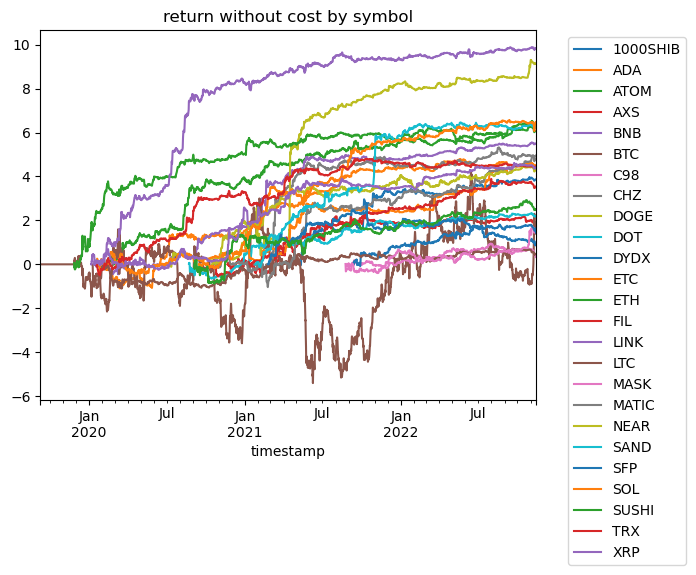

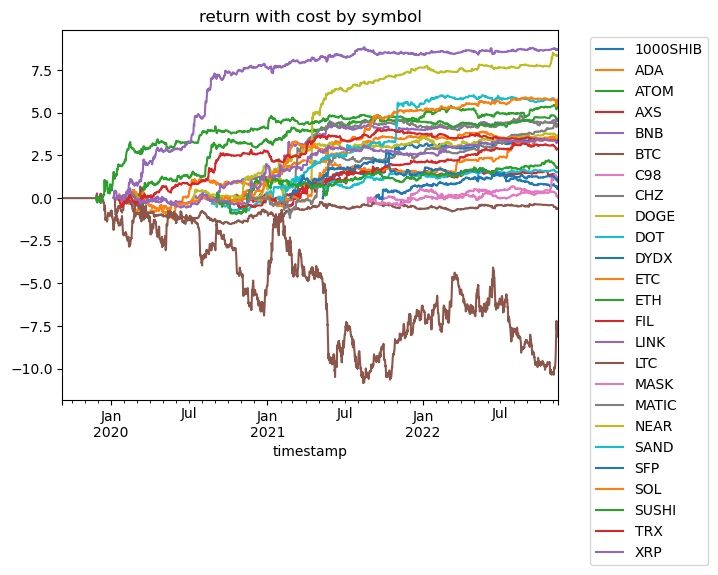

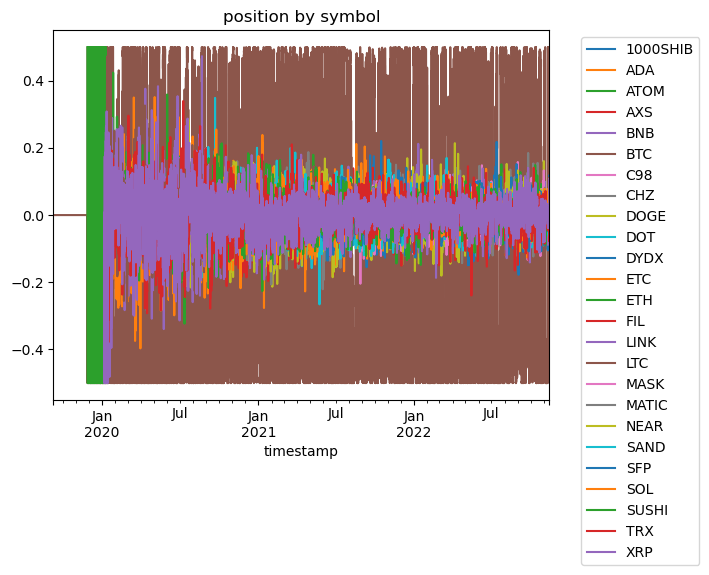

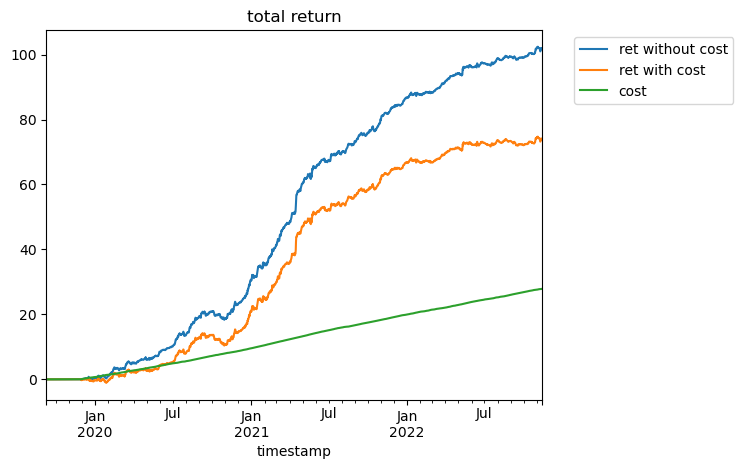

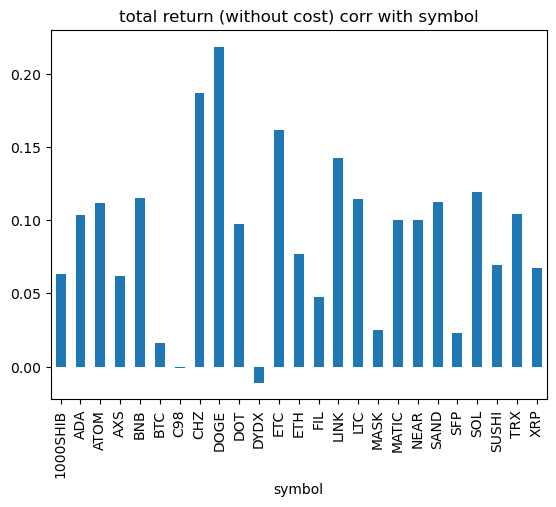

/tmp/ipykernel_12/1310906781.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/1310906781.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


fit df.shape (465012, 744)


In [6]:
df = pd.read_pickle('/tmp/df_binance_ohlcv.pkl')
df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-14 00:00:00Z')]
df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: x.shift(-25) / x.shift(-1) - 1).fillna(0)
df['execution_start_at'] = df.index.get_level_values('timestamp')

btc_timestamps = df.loc[df.index.get_level_values('symbol') == 'BTC'].index.get_level_values('timestamp')
df = df.loc[df.index.get_level_values('timestamp').isin(btc_timestamps)]

model = ExampleModelRank()

# cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20220929_btc_beta_one.xz', 'wb') as f:
    f.write(data)

/tmp/ipykernel_12/1310906781.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/1310906781.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


timestamp                  symbol  
2022-09-15 15:00:00+00:00  1000SHIB    0.020092
                           ADA         0.021514
                           ATOM        0.025799
                           AXS         0.026158
                           BNB         0.024958
                                         ...   
2022-11-14 15:00:00+00:00  SFP         0.060863
                           SOL        -0.001849
                           SUSHI       0.030154
                           TRX        -0.011806
                           XRP        -0.010511
Name: position, Length: 36025, dtype: float64
['1000SHIB', 'ADA', 'ATOM', 'AXS', 'BNB', 'BTC', 'C98', 'CHZ', 'DOGE', 'DOT', 'DYDX', 'ETC', 'ETH', 'FIL', 'LINK', 'LTC', 'MASK', 'MATIC', 'NEAR', 'SAND', 'SFP', 'SOL', 'SUSHI', 'TRX', 'XRP']
test shift predict


/tmp/ipykernel_12/1310906781.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/1310906781.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0
/tmp/ipykernel_12/1310906781.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fr

position1  position2  position3
timestamp                 symbol                                   
2022-09-15 16:00:00+00:00 1000SHIB  -0.012056  -0.012056   0.023994
                          ADA       -0.009888  -0.009888   0.019941
                          ATOM      -0.007792  -0.007792   0.023128
                          AXS       -0.011347  -0.011347   0.023034
                          BNB       -0.003287  -0.003287   0.023511
...                                       ...        ...        ...
2022-11-14 14:00:00+00:00 SFP        0.061717   0.061717   0.061821
                          SOL       -0.010465  -0.010465  -0.010483
                          SUSHI      0.042122   0.042122   0.041882
                          TRX       -0.027514  -0.027514  -0.027673
                          XRP       -0.001707  -0.001707  -0.001780

[35975 rows x 3 columns]

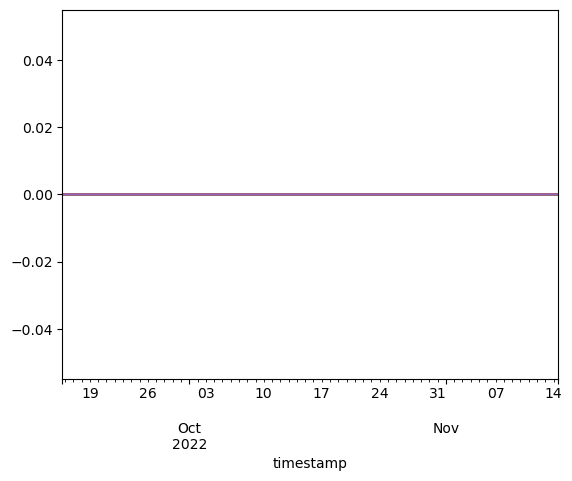

1000SHIB (1439, 4)
ADA (1439, 4)
ATOM (1439, 4)
AXS (1439, 4)
BNB (1439, 4)
BTC (1439, 4)
C98 (1439, 4)
CHZ (1439, 4)
DOGE (1439, 4)
DOT (1439, 4)
DYDX (1439, 4)
ETC (1439, 4)
ETH (1439, 4)
FIL (1439, 4)
LINK (1439, 4)
LTC (1439, 4)
MASK (1439, 4)
MATIC (1439, 4)
NEAR (1439, 4)
SAND (1439, 4)
SFP (1439, 4)
SOL (1439, 4)
SUSHI (1439, 4)
TRX (1439, 4)
XRP (1439, 4)


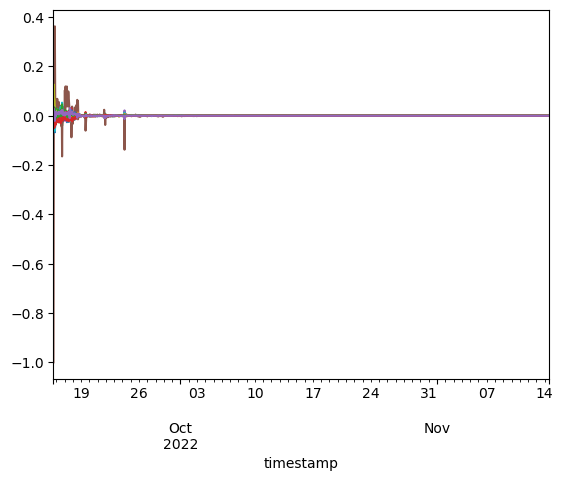

In [7]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20220929_btc_beta_one.xz')
df = pd.read_pickle('/tmp/df_binance_ohlcv.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)


print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()